In [9]:
from datetime import datetime

# SecureString parameter stored in AWS System Manager that holds a GitHub personal access token.
parameter_name = 'github_token'

# Repositories for which reports will be generated.
repo_names = [
    # Android
    'aws-amplify/amplify-android',
    'aws-amplify/aws-sdk-android',
    'awslabs/aws-mobile-appsync-sdk-android',

#     # iOS
#     'aws-amplify/amplify-ios',
#     'aws-amplify/aws-sdk-ios',
#     'awslabs/aws-mobile-appsync-sdk-ios',
    
#     # JS
#     'aws-amplify/amplify-js',
    
#     # CLI
#     'aws-amplify/amplify-cli',
    
    # Docs
    'aws-amplify/docs'
]

# Labels used across different repositories
issue_buckets = {
    'Bug': ['Bug', 'bug'],
    'Feature Request': ['Improvement', 'Feature Request', 'enhancement', 'feature-request'],
    'Question': ['Usage Question', 'Question', 'question'],
    'Pending Triage': ['Pending Triage', 'to-be-reproduced']
}

# Labels to omit from rows
omit_labels = {
    'Wont Fix', "Won't Fix", 'closing-soon-if-no-response', 'Product Review',
    'Requesting Feedback', 'Closing Soon', 'Clarification Needed', 'Duplicate',
    'Needs Info from Requester', 'work-in-progress', 'good-first-issue',
    'pending-close-response-required', 'pending-response', 'pending-release',
    'Awaiting Release', 'Investigating', 'Pending', 'Pull Request', 'duplicate',
    'good first issue', 'Reviewing', 'needs review', 'needs discussion',
    'needs-review', 'investigating', 'help wanted', 'needs-discussion',
    'Help Wanted', 'Good First Issue', 'wontfix'
}
omit_labels = omit_labels.union({label for labels in issue_buckets.values() for label in labels})

# Capture start time
start = datetime.now()

In [10]:
# Retrieve the GitHub token from SSM to prevent oops-I-pushed-credentials-to-GitHub uh-ohs.

import boto3

ssm = boto3.client('ssm')
response = ssm.get_parameter(Name=parameter_name, WithDecryption=True)
token = response['Parameter']['Value']

In [11]:
# Grab all issues from the GitHub V4 GraphQL API

import requests
import json

headers = {'Authorization': f'Bearer {token}'}


def get_issues(owner, name, *, end_cursor=None):
    query = """
    query($owner: String!, $name: String!, $endCursor: String) {
      repository(owner:$owner, name:$name) {
        issues(first:100, after:$endCursor) {
          nodes {
            number
            title
            createdAt
            closedAt
            reactions {
              totalCount
            }
            comments(first:100) {
              nodes {
                createdAt
                author {
                  login
                }
                reactions {
                  totalCount
                }
              }
            }
            labels(first:3) {
              nodes {
                name
              }
            }
          }
          pageInfo {
            hasNextPage
            endCursor
          }
        }
      }
    }"""
    
    variables = {'owner': owner, 'name': name, 'endCursor': end_cursor}
    response = execute(query, variables)
    page_info = response['data']['repository']['issues']['pageInfo']
    nodes = response['data']['repository']['issues']['nodes']
    
    for issue in nodes:
        yield issue
    
    if page_info['hasNextPage']:
        yield from get_issues(owner, name, end_cursor=page_info['endCursor'])
    
def execute(query, variables):
    request = requests.post(
        'https://api.github.com/graphql',
        json={'query': query, 'variables': variables},
        headers=headers
    )

    if request.status_code == 200:
        return request.json()
    else:
        raise Exception("{}: {}".format(request.status_code, query))

In [12]:
# Loop through each repository, grab all issues, and create a DataFrame for each.

import pandas as pd

repos = {}
bucket_lookup = {label: bucket for bucket, labels in issue_buckets.items() for label in labels}

for repo_name in repo_names:
    issues = []
    owner, name = repo_name.split('/')

    for issue in get_issues(owner, name):
        labels = pd.array([label['name'] for label in issue['labels']['nodes']])
        bucket = 'Other'
        created_at = pd.Timestamp(issue['createdAt'],tz='UTC')
        
        score = 1
        score += len(issue['comments']['nodes'])
        score += issue['reactions']['totalCount']
        score += sum(comment['reactions']['totalCount'] for comment in issue['comments']['nodes'])
        
        if issue['closedAt']:
            closed_at = pd.Timestamp(issue['closedAt'], tz='UTC')
        else:
            closed_at = None
            
        for label in labels:
            if label in bucket_lookup:
                bucket = bucket_lookup[label]
                break
                
        issues.append(
            [issue['number'], issue['title'], labels, created_at, closed_at, bucket, score]
        )
        
    repos[repo_name] = pd.DataFrame(issues, columns=[
        'id', 'title', 'labels', 'created_at', 'closed_at', 'bucket', 'score'
    ])

In [13]:
# Utility function to generate statistics (counts, MoM, WoW, etc) for a DataFrame.

import pytz
from datetime import datetime


def generate_stats(df):
    utc = pytz.timezone('UTC')

    seven_days_ago = datetime.now() - pd.Timedelta('7 days')
    seven_days_ago = seven_days_ago.astimezone(utc)

    thirty_days_ago = datetime.now() - pd.Timedelta('30 days')
    thirty_days_ago = thirty_days_ago.astimezone(utc)

    open_issues = df[~(df.closed_at > '1970-01-01')]
    last_week_closed_issues = df[(df.closed_at > seven_days_ago)]
    last_month_closed_issues = df[(df.closed_at > thirty_days_ago)]
    last_week_open_issues = df[(df.created_at < seven_days_ago) & ~(df.closed_at < seven_days_ago)]
    last_month_open_issues = df[(df.created_at < thirty_days_ago) & ~(df.closed_at < thirty_days_ago)]
    
    open_issues_count = len(open_issues.index)
    last_week_closed_issues_count = len(last_week_closed_issues.index)
    last_month_closed_issues_count = len(last_month_closed_issues.index)
    last_week_open_issues_count = len(last_week_open_issues.index)
    last_month_open_issues_count = len(last_month_open_issues.index)
    
    return [
        open_issues_count,
        last_week_open_issues_count,
        open_issues_count - last_week_open_issues_count,
        last_month_open_issues_count,
        open_issues_count - last_month_open_issues_count,
        last_week_closed_issues_count,
        last_month_closed_issues_count
    ]

In [14]:
# Using the DataFrames, process and grab the counts of issues by repo and then by bucket.

import pandas as pd
from IPython.display import display, HTML

pd.set_option('display.max_rows', 500)

for repo_name in repo_names:
    df = repos[repo_name]
    buckets = {bucket for bucket in df.bucket}
    
    row = [repo_name]
    row.extend(generate_stats(df))

    open_df = pd.DataFrame([row], columns=[
        'Repo', 'Open', 'Last Week', 'WoW', 'Last Month', 'MoM', 'Closed Last Week',
        'Closed Last Month'
    ])
    
    display(HTML(f'<h1>{repo_name}</h1>'))
    display(open_df)
    
    for bucket in sorted(buckets):
        bucket_counts = []
        issues = df.loc[df.bucket == bucket]
        labels = {label for labels in issues.labels for label in labels}
        row = [bucket, '']

        row.extend(generate_stats(issues))
        bucket_counts.append(row)
        
        for label in sorted(labels):
            if label in omit_labels or label in buckets:
                continue
            
            label_mask = issues.labels.apply(lambda l: label in l)
            label_issues = issues[label_mask]
            stats = generate_stats(label_issues)
            
            if sum(stats): 
                row = [bucket, label]
                row.extend(stats)
                bucket_counts.append(row)

        bucket_df = pd.DataFrame(bucket_counts, columns=[
            'Bucket', 'Label', 'Open', 'Last Week', 'WoW', 'Last Month', 'MoM',
            'Closed Last Week', 'Closed Last Month'
        ])
        
        display(HTML(f'<h2>{repo_name}: {bucket}'))
        display(bucket_df)

    display(HTML(f'<hr>'))

,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,aws-amplify/amplify-android,37,34,3,33,4,8,25


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,13,14,-1,16,-3,3,14
1,Bug,API,3,3,0,2,1,1,2
2,Bug,Analytics,1,1,0,0,1,0,0
3,Bug,Auth,2,2,0,3,-1,0,4
4,Bug,DataStore,7,8,-1,8,-1,1,5
5,Bug,Developer Tools,1,1,0,1,0,1,1
6,Bug,Pending Release,2,3,-1,3,-1,1,1
7,Bug,Storage,0,0,0,1,-1,0,1


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,13,12,1,13,0,0,2
1,Feature Request,API,6,6,0,5,1,0,0
2,Feature Request,Auth,1,1,0,2,-1,0,1
3,Feature Request,Core,1,1,0,1,0,0,0
4,Feature Request,DataStore,4,4,0,3,1,0,0
5,Feature Request,Developer Tools,2,1,1,1,1,0,0
6,Feature Request,Predictions,1,1,0,1,0,0,0
7,Feature Request,Storage,1,1,0,2,-1,0,1


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,7,3,4,3,4,2,6
1,Other,Auth,0,1,-1,0,0,1,1
2,Other,RFC,2,2,0,3,-1,0,1
3,Other,Storage,0,0,0,1,-1,0,1


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Pending Triage,,0,0,0,0,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,4,5,-1,1,3,3,3
1,Question,API,1,2,-1,1,0,1,1
2,Question,Auth,2,2,0,0,2,2,2
3,Question,Pending Release,0,1,-1,0,0,1,1


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,aws-amplify/aws-sdk-android,149,148,1,151,-2,1,15


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,41,40,1,39,2,0,4
1,Bug,AWSMobileClient,14,14,0,12,2,0,1
2,Bug,AppSync,1,1,0,1,0,0,0
3,Bug,Cognito,5,5,0,5,0,0,0
4,Bug,Core,1,1,0,1,0,0,0
5,Bug,IoT,4,3,1,3,1,0,0
6,Bug,KinesisVideo,2,2,0,2,0,0,0
7,Bug,Lambda,3,3,0,3,0,0,0
8,Bug,Pinpoint,3,3,0,3,0,0,0
9,Bug,S3,6,6,0,7,-1,0,3


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,64,65,-1,66,-2,1,3
1,Feature Request,APIGateway,1,1,0,1,0,0,0
2,Feature Request,AWSMobileClient,16,16,0,17,-1,0,1
3,Feature Request,Cognito,12,13,-1,14,-2,1,2
4,Feature Request,Core,5,5,0,5,0,0,0
5,Feature Request,Documentation,1,1,0,1,0,0,0
6,Feature Request,DynamoDB,1,1,0,0,1,0,0
7,Feature Request,IoT,12,12,0,12,0,0,0
8,Feature Request,KinesisVideo,1,1,0,1,0,0,0
9,Feature Request,Lambda,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,14,14,0,16,-2,0,5
1,Other,AWSMobileClient,7,7,0,9,-2,0,2
2,Other,Cognito,3,3,0,4,-1,0,1
3,Other,DynamoDB,1,1,0,1,0,0,0
4,Other,IoT,1,1,0,1,0,0,0
5,Other,Sample App,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,30,29,1,30,0,0,3
1,Question,APIGateway,4,4,0,3,1,0,0
2,Question,AWSMobileClient,12,11,1,14,-2,0,3
3,Question,Cognito,6,6,0,6,0,0,0
4,Question,Core,2,2,0,2,0,0,0
5,Question,Documentation,1,1,0,1,0,0,0
6,Question,IoT,2,2,0,2,0,0,0
7,Question,KinesisVideo,1,1,0,1,0,0,0
8,Question,Pinpoint,2,2,0,2,0,0,0
9,Question,S3,2,2,0,1,1,0,0


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,awslabs/aws-mobile-appsync-sdk-android,56,57,-1,53,3,1,1


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,24,24,0,21,3,0,0
1,Bug,AppSync,22,22,0,20,2,0,0
2,Bug,Codegen,2,2,0,2,0,0,0
3,Bug,Documentation,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,14,14,0,14,0,0,0
1,Feature Request,AppSync,13,13,0,13,0,0,0
2,Feature Request,Codegen,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,8,9,-1,9,-1,1,1
1,Other,AppSync,2,2,0,2,0,0,0
2,Other,Codegen,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,10,10,0,9,1,0,0
1,Question,AppSync,10,10,0,9,1,0,0
2,Question,Documentation,1,1,0,1,0,0,0
3,Question,Infrastructure,1,1,0,1,0,0,0


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,aws-amplify/docs,88,82,6,72,16,3,33


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,2,2,0,1,1,0,1
1,Bug,Android,1,1,0,0,1,0,0
2,Bug,CLI,1,1,0,1,0,0,0
3,Bug,Getting Started,0,0,0,0,0,0,1
4,Bug,iOS,1,1,0,0,1,0,1


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,13,14,-1,13,0,1,5
1,Feature Request,Android,1,2,-1,1,0,1,2
2,Feature Request,Auth,2,2,0,1,1,0,1
3,Feature Request,CLI,1,2,-1,3,-2,1,2
4,Feature Request,Docs Site (Itself),2,2,0,2,0,0,1
5,Feature Request,JavaScript,7,7,0,5,2,0,0
6,Feature Request,iOS,1,1,0,1,0,0,0
7,Feature Request,pending-close-if-no-response,1,1,0,2,-1,0,1


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,73,66,7,58,15,2,27
1,Other,Android,3,2,1,2,1,0,4
2,Other,Auth,5,4,1,4,1,0,0
3,Other,CLI,10,11,-1,11,-1,1,4
4,Other,Detailed Needed from Requester,3,3,0,2,1,0,5
5,Other,Docs Site (Itself),2,2,0,2,0,0,1
6,Other,Flutter,3,2,1,0,3,0,0
7,Other,Getting Started,2,2,0,4,-2,0,2
8,Other,JavaScript,44,43,1,38,6,0,4
9,Other,Pending Release,1,1,0,0,1,0,0


In [15]:
##### Top Open Bugs by Activity

from IPython.core.display import HTML

pd.set_option('display.max_colwidth', None)

display(HTML(f'<h1>Top Open Bugs by Activity</h1>'))

for repo_name, df in repos.items():
    df = df.loc[df.bucket == 'Bug']
    df = df[~(df.closed_at > '1970-01-01')]
    df = df.sort_values(axis=0, by=['score'], ascending=False)

    display(HTML(f'<h2>{repo_name}</h2>'))
    display(df[['id', 'title', 'created_at', 'labels', 'score']].head(15))

# Top Open Feature Requests by Activity

display(HTML(f'<h1>Top Open Feature Requests by Activity</h1>'))

for repo_name, df in repos.items():
    df = df.loc[df.bucket == 'Feature Request']
    df = df[~(df.closed_at > '1970-01-01')]
    df = df.sort_values(axis=0, by=['score'], ascending=False)
    
    display(HTML(f'<h2>{repo_name}</h2>'))
    display(df[['id', 'title', 'created_at', 'labels', 'score']].head(15))

,id,title,created_at,labels,score
64,464,Synchronization Error with relations,2020-05-14 20:46:43+00:00,"[Bug, DataStore]",10
140,702,"""Validation error of type SubSelectionRequired"" during sync",2020-08-06 06:57:03+00:00,"[Bug, DataStore, Pending Release]",10
148,731,Websocket connection failed when trying to subscribe,2020-08-17 12:43:55+00:00,"[Bug, DataStore]",10
68,487,DataStore multiple one has many relation error,2020-05-19 14:46:42+00:00,"[Bug, DataStore]",9
124,666,"""createdAt: AWSDateTime"" in schema causes Datastore query failure",2020-07-24 13:16:32+00:00,"[Bug, DataStore]",6
134,683,Unable to login on user created from cognito console,2020-07-30 12:50:52+00:00,"[Auth, Bug]",6
163,793,Bug in Generated Amplify GraphQL Object - NullPointer for DateTime Object,2020-09-03 10:41:12+00:00,"[API, Bug]",6
73,536,ERROR: Node.js is not installed (EACCESS error),2020-05-27 13:44:33+00:00,"[Bug, Developer Tools]",4
139,699,Owner auth API provisioned with CLI 4.22.1 without read operation do not require owner input on subscription API,2020-08-05 20:26:20+00:00,"[API, Bug, Pending Release]",4
160,781,Amplify API and DataStore ValidationError when querying or mutating data,2020-09-01 01:36:32+00:00,"[API, Bug, DataStore]",2


,id,title,created_at,labels,score
801,1259,AWSIotMqttManager NoClassDefFoundError with Android < 7,2019-10-16 19:36:15+00:00,"[Bug, IoT]",51
985,2063,Could not check if ACCESS_NETWORK_STATE permission is available warning in 2.17.1,2020-08-11 22:31:33+00:00,"[AWSMobileClient, Awaiting Release, Bug]",31
895,1507,Logged out after changing permission,2020-03-06 09:29:30+00:00,"[AWSMobileClient, Bug]",27
695,1003,AWSMobileClient.getInstance().showSignIn() buttons do not work after sign-out or invalid token,2019-06-02 04:34:37+00:00,"[AWSMobileClient, Bug]",22
803,1264,NullPointerException Attempt to invoke virtual method 'java.lang.String com.amazonaws.services.cognitoidentityprovider.model.CodeDeliveryDetailsType.getDestination()' on a null object reference,2019-10-21 12:43:01+00:00,"[AWSMobileClient, Bug]",15
680,956,Sign in issue in AmazonKinesisVideoDemoApp,2019-05-13 21:40:47+00:00,"[AWSMobileClient, Bug]",15
990,2084,AWSMobileClient getTokens is slow to return new token,2020-08-19 14:57:05+00:00,"[AWSMobileClient, Bug]",13
955,1827,No cached session if app is inactive for some time,2020-06-05 14:07:23+00:00,"[AWSMobileClient, Bug]",10
886,1495,getUsername() returning null,2020-02-29 19:51:26+00:00,"[AWSMobileClient, Bug]",7
791,1232,"S3 GetObject request failing with ""More data read(78279) than expected"" error.",2019-10-04 06:53:24+00:00,"[Bug, S3]",6


,id,title,created_at,labels,score
146,246,"Subscription initialization throws ""Invalid message type string"" exception when token has expired",2020-01-15 15:23:59+00:00,"[AppSync, Bug]",12
150,257,Subscriptions don't work in 3.0.x; NullPointerException on AWSConfiguration object,2020-02-04 08:58:26+00:00,"[AppSync, Bug]",10
86,136,IOException/SocketTimeoutException not propagated to GraphQLCall.Callback and Appsync goes into a long loop of retrying,2019-03-26 18:42:58+00:00,"[AppSync, Bug]",8
122,206,Disabling cache not working in Appsync / appollo,2019-07-18 21:06:12+00:00,"[AppSync, Bug]",8
123,207,Delta sync base query always runs again after process restart,2019-07-23 06:08:10+00:00,"[AppSync, Bug]",8
119,203,AppSync submits mutations with big delays,2019-07-17 23:07:16+00:00,"[AppSync, Bug]",6
78,127,Apollo mapping not working with Appsync Gradle plugin 2.7.8,2019-03-07 11:58:12+00:00,"[AppSync, Bug, Codegen]",6
126,211,"When subscribing, getting - ApolloException: Connection Error Reported",2019-08-26 11:07:45+00:00,"[AppSync, Bug]",5
175,307,Gradle cannot sync: Unable to find method 'org.gradle.api.internal.file.DefaultSourceDirectorySet ...,2020-08-12 23:01:45+00:00,"[AppSync, Bug]",5
104,163,Multidimensional array support,2019-04-29 12:43:50+00:00,"[AppSync, Bug, Codegen]",5


,id,title,created_at,labels,score
628,2323,[Feedback]iOS API Subscription guide is in JS when it should be in Swift,2020-08-28 15:31:21+00:00,"[Android, Bug, iOS]",3
475,1910,"Error in the section ""Ownership with create mutations""",2020-06-03 19:08:16+00:00,"[Bug, CLI]",2


,id,title,created_at,labels,score
125,667,Support OIDC providers via @auth directive,2020-07-24 13:30:51+00:00,"[API, DataStore, Feature Request]",11
66,469,Support InputStream for content scheme,2020-05-15 18:23:10+00:00,"[Improvement, Storage]",7
147,725,Todo example fails sync with Validation error of type FieldUndefined: Field 'syncTodos' in type 'Query',2020-08-14 11:19:33+00:00,"[API, DataStore, Improvement]",6
167,800,Developer Menu can't be disabled in Debug Mode,2020-09-04 15:43:57+00:00,"[Developer Tools, Feature Request]",6
129,674,Allow custom queryField in Amplify DataStore or API,2020-07-27 16:45:34+00:00,"[API, DataStore, Feature Request]",4
46,303,Using Custom GraphQL Endpoint,2020-03-13 08:49:34+00:00,"[API, Feature Request]",3
82,560,Developers would like to reconfigure Amplify at runtime,2020-06-05 11:30:46+00:00,"[Core, Feature Request]",3
127,671,Request for Auth.getPreferredMFA(...) for JavaScript parity,2020-07-15 07:56:57+00:00,"[Auth, Feature Request]",3
23,210,[API] GraphQL - Support for different Id fields and range keys,2020-01-02 17:12:42+00:00,"[API, Feature Request]",2
78,551,Support Transcribe Streaming in Predictions,2020-06-03 18:27:02+00:00,"[Feature Request, Predictions]",1


,id,title,created_at,labels,score
572,684,Custom scopes in access token programmatically,2019-02-02 19:28:41+00:00,"[Cognito, Feature Request]",271
442,505,Upload multiple files using TransferUtility,2018-08-04 17:50:33+00:00,"[Feature Request, S3]",36
858,1436,TransferUtility upload - Support InputStream and FileDescriptor instead of only File,2020-01-17 00:06:38+00:00,"[Feature Request, S3]",31
476,547,Add Secrets Manager to Android and iOS SDKs,2018-10-16 19:30:45+00:00,"[Core, Feature Request]",20
778,1204,Please provide refreshSession() method in AWSMobileClient for getting latest access token,2019-09-18 08:42:11+00:00,"[AWSMobileClient, Feature Request]",15
523,611,S3 TransferUtility: Lower the minimum notification threshold of 128KB,2018-12-12 21:50:21+00:00,"[Feature Request, S3]",15
468,539,AuthClient throws error when missing Chrome CustomTabs,2018-10-05 14:15:43+00:00,"[Cognito, Feature Request]",14
541,636,[IoT] Support generation of presigned URL for IoT endpoint,2019-01-08 05:20:17+00:00,"[Feature Request, IoT]",13
579,696,Manually expire or invalidate tokens and get new issued.,2019-02-11 14:06:10+00:00,"[Cognito, Feature Request]",13
457,524,"AWS - Auth social login, facebook and g+ session retain in browser",2018-09-04 11:37:00+00:00,"[Cognito, Feature Request]",12


,id,title,created_at,labels,score
46,79,Implement callback to specify a custom retry policy,2018-12-05 20:38:19+00:00,"[AppSync, Feature Request]",23
41,74,RXJava support,2018-12-03 07:30:45+00:00,"[AppSync, Feature Request]",12
99,155,Use Android apollo-client as a dependency instead of modifying its code,2019-04-23 10:19:40+00:00,"[AppSync, Feature Request]",12
68,113,Including Mutation Payload in PersistentMutationsError of PersistentMutationsCallback,2019-02-05 14:15:58+00:00,"[AppSync, Feature Request]",7
38,70,How can I know the time when a subscription has been started.,2018-11-28 10:53:46+00:00,"[AppSync, Feature Request]",5
110,188,Multiple file upload does not work,2019-06-05 01:23:41+00:00,"[AppSync, Feature Request]",5
168,299,Generate Kotlin code,2020-06-23 04:59:54+00:00,"[AppSync, Feature Request]",5
149,254,Cannot serialize Kotlin type com.apollographql.apollo.compiler.ir.CodeGenerationIR. Reflective serialization of Kotlin classes without using kotlin-reflect has undefined and unexpected behavior.,2020-01-27 15:54:59+00:00,"[AppSync, Feature Request]",3
52,94,Subscription retry even when the first request is unsuccessful,2019-01-07 14:56:05+00:00,"[AppSync, Feature Request]",2
85,135,Support `null` literal for optional fields,2019-03-20 20:59:00+00:00,"[AppSync, Feature Request]",2


,id,title,created_at,labels,score
184,755,Add Documentation for Other Auth Providers,2019-06-26 11:48:04+00:00,"[Feature Request, JavaScript]",27
453,1813,[Feedback]Allow hiding of left and/or right panes in the docs,2020-05-23 02:08:16+00:00,"[Docs Site (Itself), Feature Request]",6
420,1699,Rewrite the CLI workflows doc,2020-05-02 23:29:15+00:00,"[CLI, Feature Request]",4
492,1966,Provide documentation on how to use Amplify with existing resources,2020-06-16 14:35:19+00:00,"[Feature Request, pending-close-if-no-response]",4
576,2174,What is in Amplify.configure(awsconfig);,2020-08-02 02:56:11+00:00,"[Auth, Feature Request, JavaScript]",4
276,1064,Improve push notifications documentation,2019-12-14 10:40:31+00:00,"[Feature Request, JavaScript]",3
543,2077,DataStore limitations,2020-07-08 09:24:22+00:00,"[Feature Request, JavaScript]",3
594,2224,[Feedback]Update needed for Ionic Amplify Tutorial,2020-08-11 03:49:12+00:00,"[Feature Request, JavaScript]",3
620,2306,Add Documentation for Custom Auth,2020-08-26 20:13:36+00:00,"[Android, Auth, Feature Request]",2
542,2075,"iOS ""Project Setup"" documentation should be updated to cover SwiftUI Apps using @main",2020-07-07 22:33:05+00:00,"[Feature Request, iOS]",1


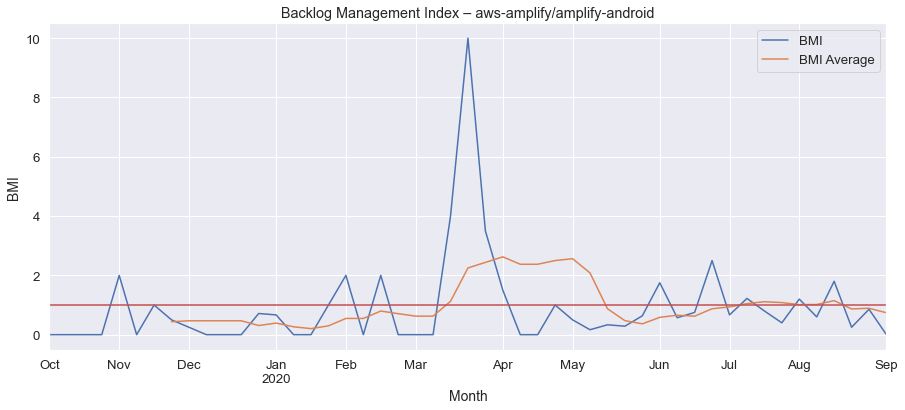

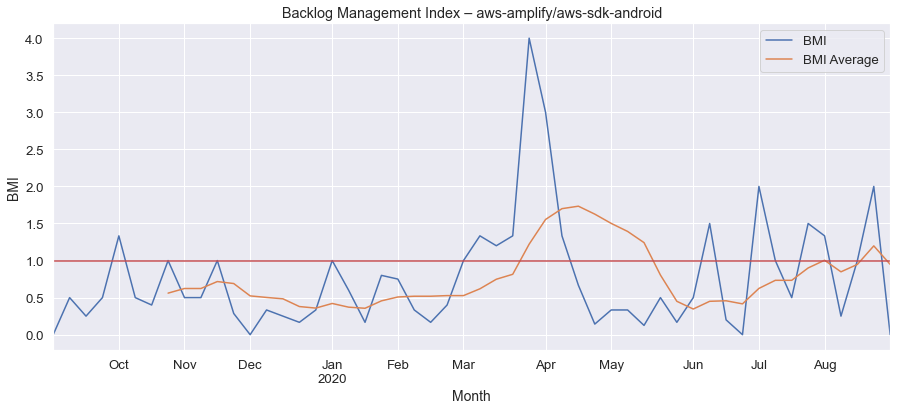

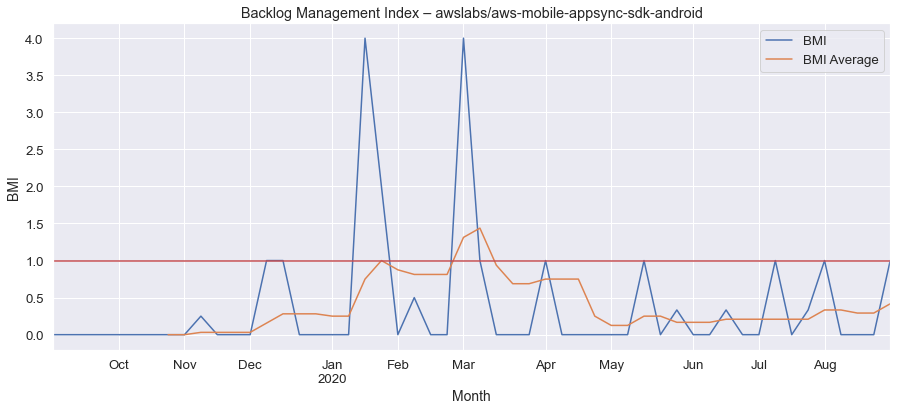

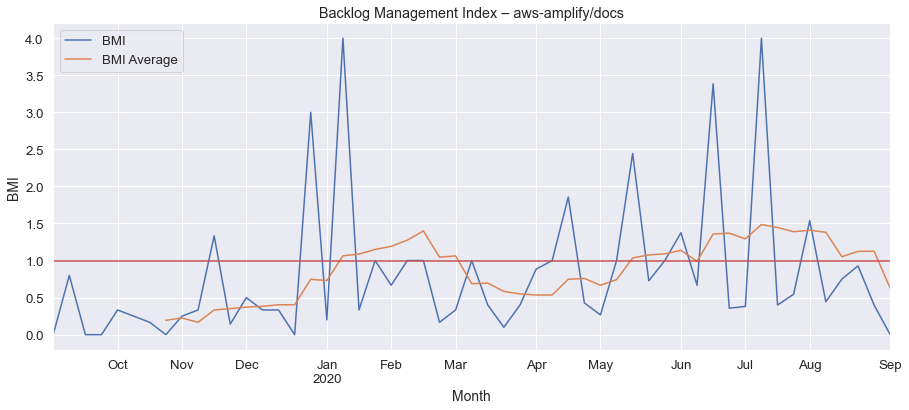

In [16]:
# Backlog Management Index

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)

sns.set(font_scale=1.2)
%matplotlib inline

for repo_name, df in repos.items(): 
    df = df.loc[df.created_at > now - timedelta(weeks=52)] 

    opened = df.set_index('created_at')
    opened = opened.id.resample('W', label='left').count().transpose().to_frame('count')
    closed = df.dropna().set_index('closed_at').sort_values(by='closed_at')
    closed = closed.id.resample('W', label='left').count().transpose().to_frame('count')

    both = opened.join(closed, how='outer', lsuffix='_opened', rsuffix='_closed')
    both.index = both.index.rename('date')
    both = both.rename(columns={'count_opened': 'Opened', 'count_closed': 'Closed'})

    both['Closed'] = both['Closed'].fillna(0)
    both['Opened'] = both['Opened'].fillna(0)
    both['BMI'] = both['Closed'] / both['Opened']
    both['BMI'] = both['BMI'].replace([np.inf, -np.inf], np.nan)
    both['BMI'] = both['BMI'].fillna(both['Closed'])

    both['BMI Average'] = both['BMI'].rolling(window=8).mean()

    ax = both[['BMI', 'BMI Average']].plot(kind='line', figsize=(15, 6), legend=True)
    ax.set_xlabel('Month', fontsize=14)
    ax.set_ylabel('BMI', fontsize=14)
    
    ax.set(title=f'Backlog Management Index – {repo_name}')
    
    plt.axhline(y=1.0, color='r', linestyle='-')
    plt.show()

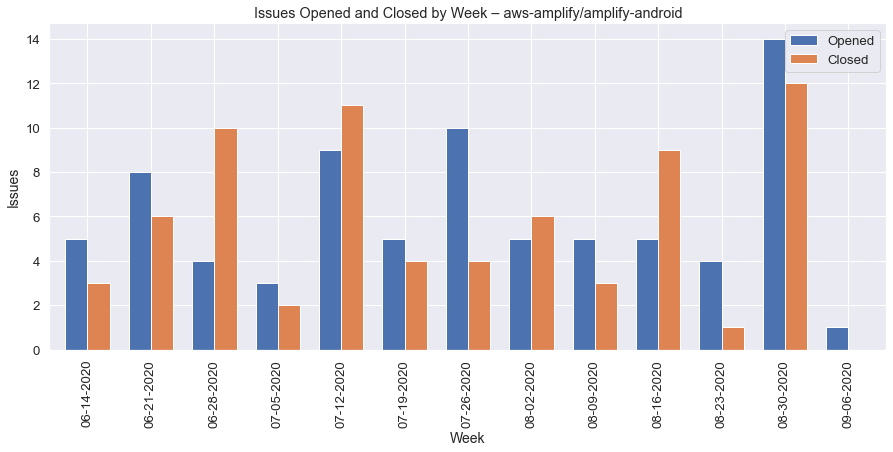

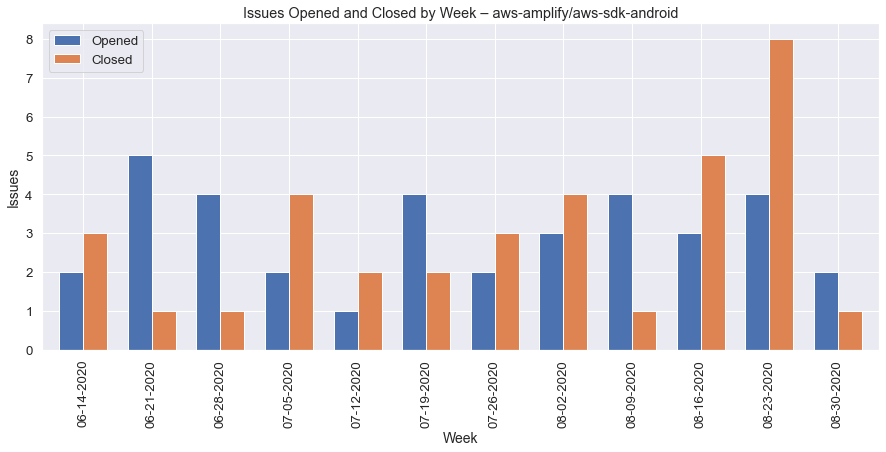

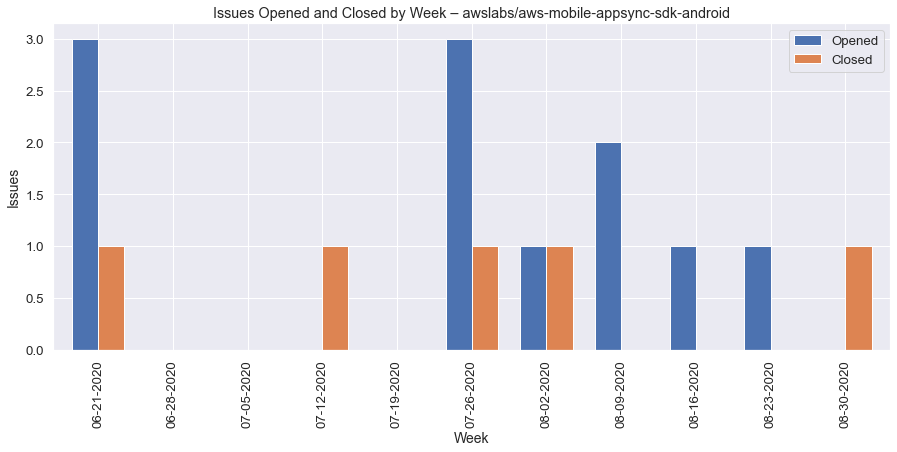

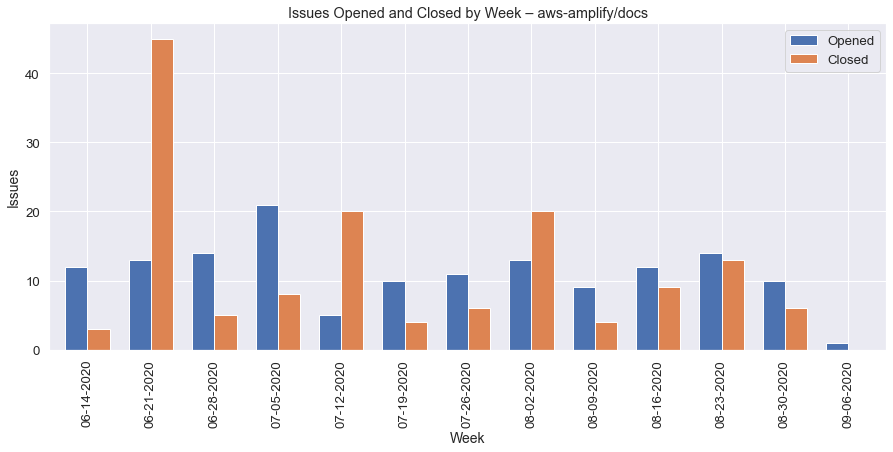

In [17]:
# Issues Opened and Closed by Week

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)

sns.set(font_scale=1.2)
%matplotlib inline

for repo_name, df in repos.items():
    opened = df.loc[(df.created_at > now - timedelta(weeks=12))] 
    closed = df.loc[(df.closed_at > now - timedelta(weeks=12))] 
    
    opened = opened.set_index('created_at')
    opened = opened.id.resample('W', label='left').count().transpose().to_frame('count')
    closed = closed.dropna().set_index('closed_at').sort_values(by='closed_at')
    closed = closed.id.resample('W', label='left').count().transpose().to_frame('count')

    both = opened.join(closed, how='outer', lsuffix='_opened', rsuffix='_closed')
    both.index = both.index.rename('date')
    both = both.rename(columns={'count_opened': 'Opened', 'count_closed': 'Closed'})
    ax = both[['Opened','Closed']].plot(kind='bar', width=0.7, figsize=(15, 6), legend=True)

    ax.set_xlabel('Week', fontsize=14)
    ax.set_ylabel('Issues', fontsize=14)
    ax.set_xticklabels(both.index.strftime('%m-%d-%Y'))
    ax.set(title=f'Issues Opened and Closed by Week – {repo_name}')
    
    plt.show()

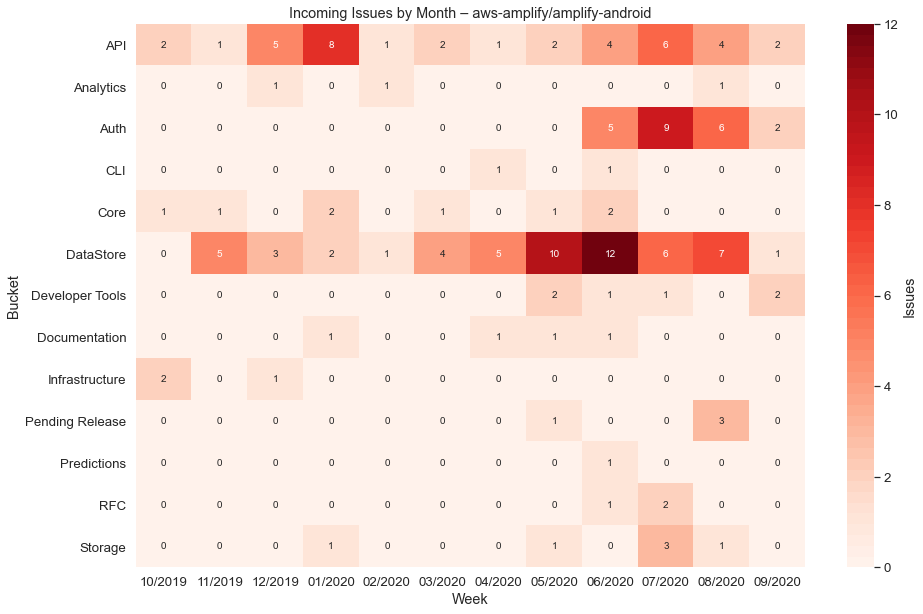

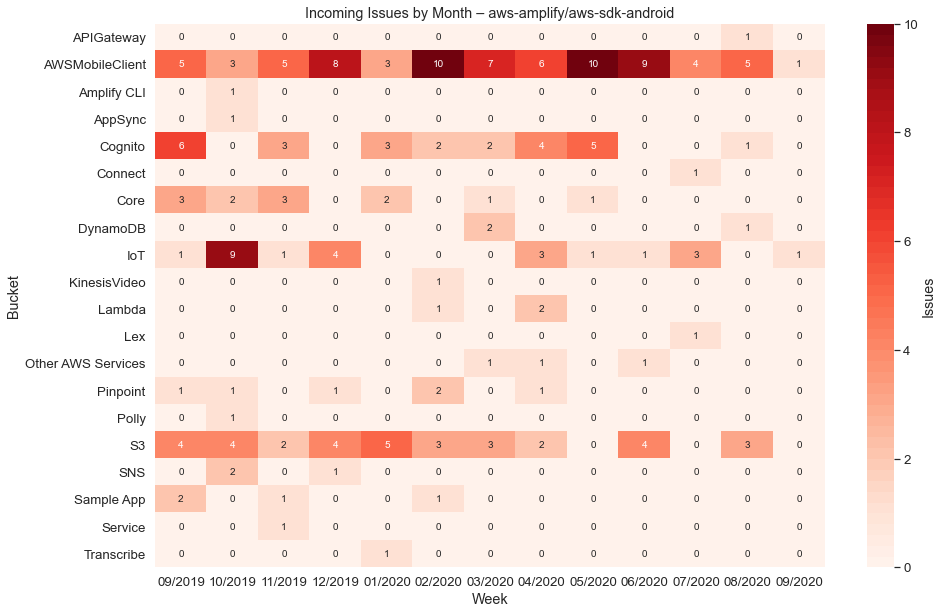

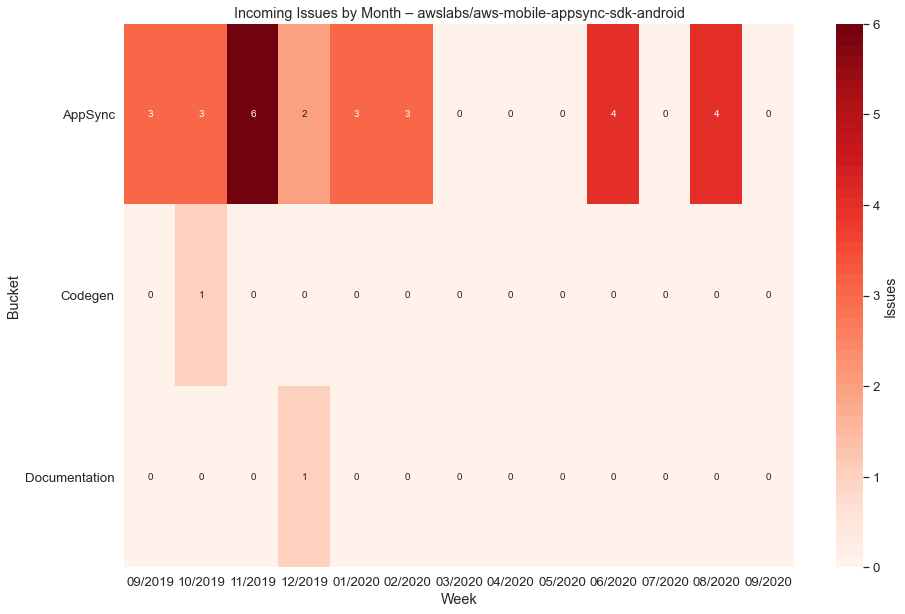

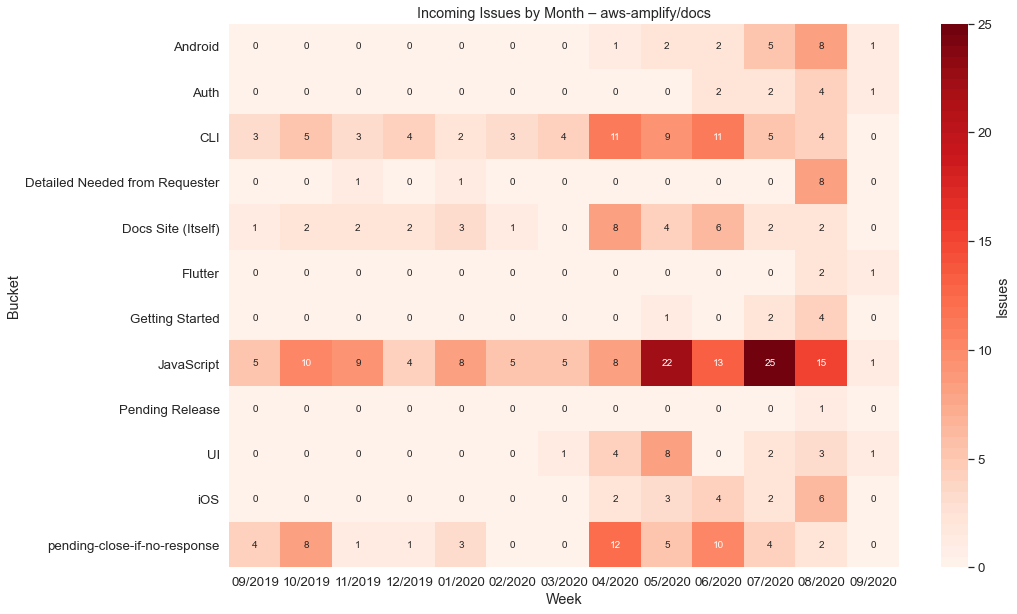

In [18]:
# Incoming Issues by Month

from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)
idx = pd.date_range(now - timedelta(weeks=12), now, freq='W')   

sns.set(font_scale=1.2)

%matplotlib inline

for repo_name, df in repos.items():    
    df = df.loc[df.created_at > now - timedelta(weeks=52)] 
    df = df.loc[np.array(list(map(len, df.labels.values))) > 0]
    df = df.labels.apply(pd.Series).merge(df, left_index = True, right_index = True)
    df = df.drop(["labels"], axis = 1)
    df = df.melt(id_vars = ['id', 'title', 'bucket', 'created_at', 'closed_at', 'score'], value_name = 'label')
    df = df.dropna(subset=['label'])
    df = df.loc[df.label.apply(lambda l: l not in issue_buckets.keys())]
    df = df.loc[df.label.apply(lambda l: l not in omit_labels)]
    df = df.pivot(index='created_at', columns='label', values='created_at')
    df = pd.concat([df, pd.DataFrame(index=[date for date in idx])])    
    df = df.resample('M', label='right').count().transpose()
    
    if (len(df)):
        plt.subplots(figsize=(15, 10))

        dates = df.columns.strftime('%m/%Y').unique()
        ax = sns.heatmap(df, xticklabels=dates, cmap=sns.color_palette("Reds", 50), fmt='.0f', annot=True,
                         cbar_kws={'label': 'Issues'})

        ax.set(xlabel='Week', ylabel='Bucket', title=f'Incoming Issues by Month – {repo_name}')
        plt.yticks(rotation=0)
        plt.show()

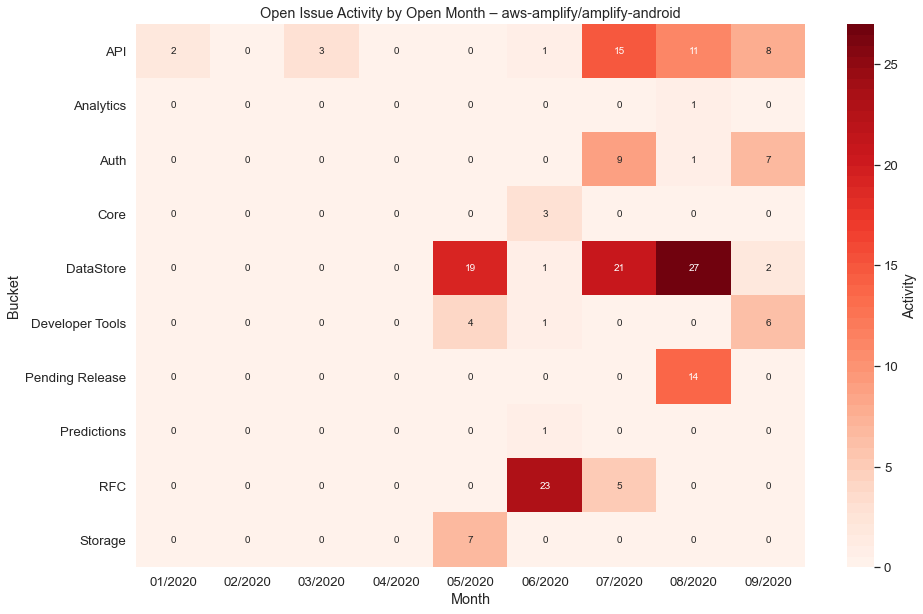

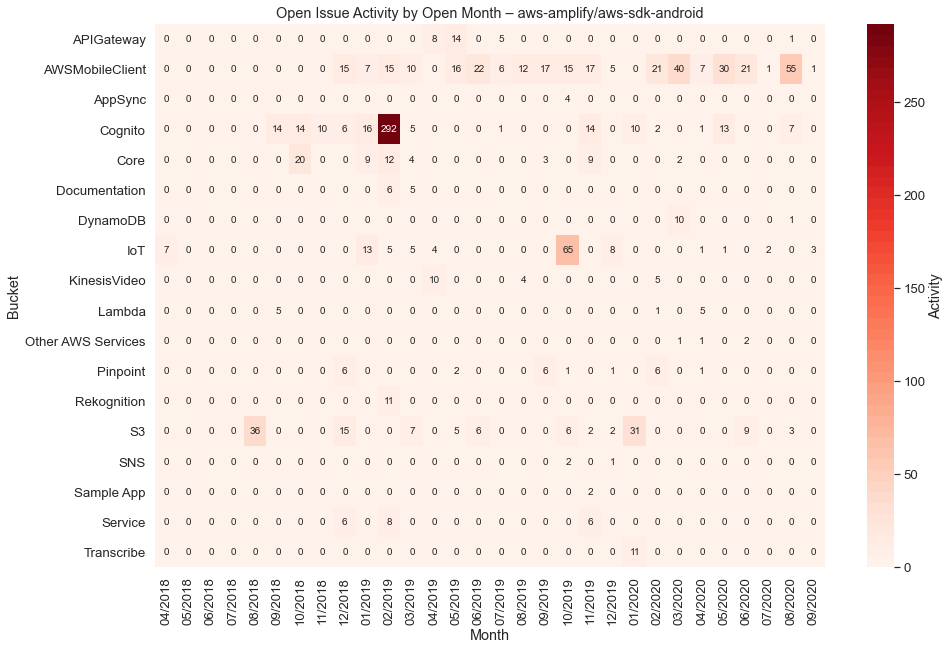

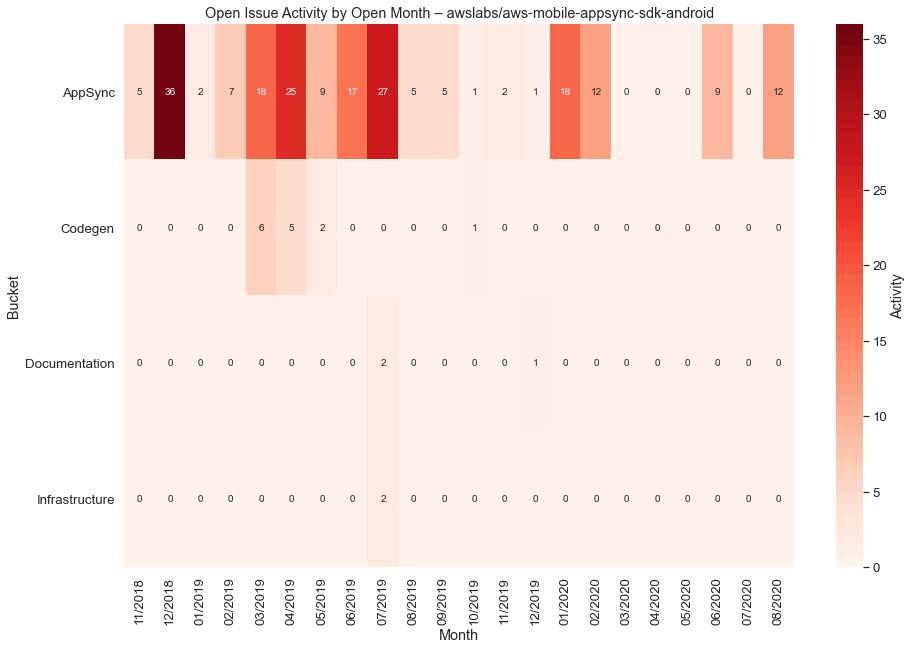

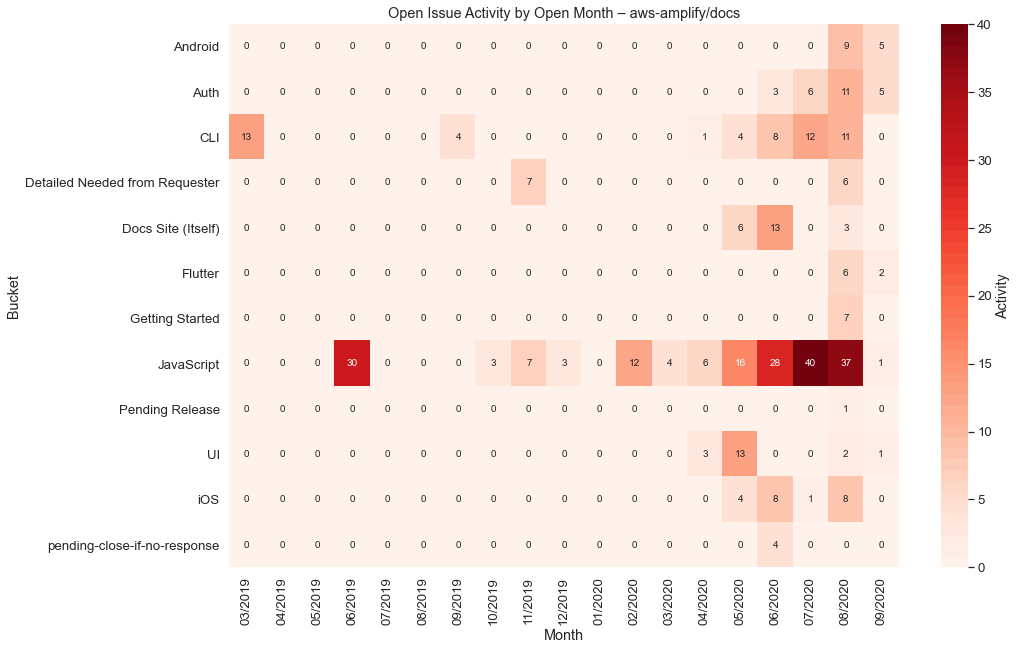

In [19]:
# Open Issues Activity by Open Month

from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)

sns.set(font_scale=1.2)

%matplotlib inline

for repo_name, df in repos.items():
    plt.subplots(figsize=(15, 10))
    
    df = df[~(df.closed_at > '1970-01-01')]
    df = df.loc[np.array(list(map(len, df.labels.values))) > 0]
    df = df.labels.apply(pd.Series).merge(df, left_index = True, right_index = True)
    df = df.drop(["labels"], axis = 1)
    df = df.melt(id_vars = ['id', 'title', 'bucket', 'created_at', 'closed_at', 'score'], value_name = 'label')
    df = df.dropna(subset=['label'])
    df = df.loc[df.label.apply(lambda l: l not in issue_buckets.keys())]
    df = df.loc[df.label.apply(lambda l: l not in omit_labels)]
    df = df.pivot(index='created_at', columns='label', values='score')
    df = df.resample('M', label='right').sum().transpose()

    dates = df.columns.strftime('%m/%Y')
    ax = sns.heatmap(df, xticklabels=dates, cmap=sns.color_palette('Reds', 50), annot=True, fmt='.0f',
                     cbar_kws={'label': 'Activity'})
    ax.set(xlabel='Month', ylabel='Bucket', title=f'Open Issue Activity by Open Month – {repo_name}')

    plt.yticks(rotation=0)
    plt.show()

In [20]:
##### Closed Issue Report

from IPython.core.display import HTML

pd.set_option('display.max_colwidth', None)

display(HTML(f'<h1>Closed Issues</h1>'))

seven_days_ago = datetime.now() - pd.Timedelta('7 days')
seven_days_ago = seven_days_ago.astimezone(pytz.timezone('UTC'))

for repo_name, df in repos.items():
    df = df[(df.closed_at > seven_days_ago)]
    df = df.sort_values(axis=0, by=['score'], ascending=False)

    display(HTML(f'<h2>{repo_name}</h2>'))
    display(df[['id', 'title', 'created_at', 'closed_at', 'labels', 'score']])

,id,title,created_at,closed_at,labels,score
117,644,"AWS api gateway, returning {""message"":""Forbidden""}",2020-07-16 12:30:41+00:00,2020-09-04 12:32:00+00:00,"[API, Usage Question]",8
63,461,DataStore initial sync fails when using relations & DynamoDB tables have too many records,2020-05-14 11:51:02+00:00,2020-09-03 14:59:06+00:00,"[Bug, DataStore, Pending Release]",7
159,780,Instances in which cognito identity defers from user login identity,2020-08-31 21:11:38+00:00,2020-09-01 17:15:00+00:00,"[Auth, Clarification Needed]",6
154,753,[Feedback] AmplifyException {message=Sign in with web UI failed ...,2020-08-24 11:40:39+00:00,2020-09-04 12:20:02+00:00,"[Auth, Closing Soon, Usage Question]",5
164,794,Disable Amplify Developer Menu,2020-09-03 11:09:23+00:00,2020-09-03 16:08:23+00:00,"[Bug, Developer Tools]",5
155,755,Can't Catch Authentication Exception With Hub on Android,2020-08-25 13:57:15+00:00,2020-09-03 17:08:58+00:00,"[Auth, Pending Release, Usage Question]",4
158,778,Seems out of place that we are checking ModelOperation in isOwnerArgumentRequired,2020-08-31 18:57:45+00:00,2020-09-01 22:53:42+00:00,"[API, Bug]",2
162,791,graphql mutation returning null on update,2020-09-03 09:29:31+00:00,2020-09-03 10:13:14+00:00,[],2


,id,title,created_at,closed_at,labels,score
753,1136,Migrate users with a Lambda Trigger,2019-08-19 13:35:34+00:00,2020-09-01 18:57:45+00:00,"[Cognito, Feature Request]",27


,id,title,created_at,closed_at,labels,score
167,298,"Android Appsync with multiple complex objects only saving one image to s3, but not storing anything in dynamodb",2020-06-22 10:55:02+00:00,2020-09-01 21:49:44+00:00,[],1


,id,title,created_at,closed_at,labels,score
177,735,Document awsconfiguration.json format and usage,2019-06-13 16:55:50+00:00,2020-09-04 07:33:06+00:00,"[Android, CLI, Feature Request]",48
512,2025,[Feedback]@Connection limit set to 10 by default,2020-06-27 12:13:16+00:00,2020-09-05 07:48:43+00:00,"[CLI, pending-close-if-no-response]",5
637,2355,graphql mutation returning null on update,2020-09-03 09:30:55+00:00,2020-09-04 08:52:13+00:00,[],5


In [21]:
from datetime import datetime
from IPython.display import display, HTML

total = (datetime.now() - start).seconds
minutes, seconds = divmod(total, 60)

if minutes:
    display(HTML(f'<em>Report generation took {minutes}min, {seconds}sec'))
else:
    display(HTML(f'<em>Report generation took {seconds}sec'))